In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

#Imports

In [ ]:
!git clone --recursive https://github.com/microsoft/LightGBM
!cd LightGBM
!mkdir build
!cd build
!cmake ..
!make -j4

Cloning into 'LightGBM'...
remote: Enumerating objects: 25087, done.
remote: Counting objects: 100% (763/763), done.
remote: Compressing objects: 100% (415/415), done.
remote: Total 25087 (delta 492), reused 551 (delta 341), pack-reused 24324
Receiving objects: 100% (25087/25087), 18.69 MiB | 22.02 MiB/s, done.
Resolving deltas: 100% (18441/18441), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Co

In [ ]:
!pip install xgboost

In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
import torch
import random
import pickle
import os
import json
import glob
import hashlib
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Graph Loading and Transformation

In [ ]:
GRAPH_PATHS = "/content/drive/MyDrive/data/processed_graphs.csv"
LABELS_PATHS = "/content/drive/MyDrive/data/processed_graphs_labels.csv"

In [ ]:
graphs = pd.read_csv(GRAPH_PATHS)
labels_df = pd.read_csv(LABELS_PATHS)

In [ ]:
def get_after_date(graphs, dt, format="%Y-%m-%d"):
  filt = graphs.index.get_level_values('date') > datetime.datetime.strptime(dt, format).date()
  return graphs[filt].copy()
def get_id_drop_idx(graphs, id):
  filt = graphs['idx'] == id
  new_graph = graphs[filt].copy()
  return new_graph.reset_index().drop("idx",axis=1)

In [ ]:
# convert this edgelist dataframe to graph and set node attributes
def convert_df_graph(df):
  df["date"] = df["date"].astype(str)
  G = nx.convert_matrix.from_pandas_edgelist(df, "from", "to", edge_attr=True,create_using=nx.MultiDiGraph())
  node_attrs = {}
  for node in G.nodes():
    node_attrs[node] = {"addr": node}

  for src, dest, data in G.edges(data=True):
    node_attrs[src]["isPhi"] = bool(data["fromIsPhi"])
    node_attrs[dest]["isPhi"] = bool(data['toIsPhi'])

  nx.classes.function.set_node_attributes(G, node_attrs)
  return G

In [ ]:
PATH_TO_GRAPHS = "/content/drive/MyDrive/data/graphs.pkl"

In [ ]:
graphs

,idx,date,Unnamed: 0,from,to,amount,timestamp,fromIsPhi,toIsPhi,isPhi,Unnamed: 0.1
0,0,2016-11-30,87613,644996311924151884824924215840682271362850202643,1249665516472213179549841288377450362199154772633,0.984401,1.480464e+09,0,0,0,NaN
1,0,2016-11-30,87614,644996311924151884824924215840682271362850202643,119639879959584517570242490761449175088357594858,98.431564,1.480465e+09,0,0,0,NaN
2,0,2016-11-30,87615,644996311924151884824924215840682271362850202643,154744709618196328765779089700513530202844453134,11.650149,1.480466e+09,0,0,0,NaN
3,0,2016-11-30,87616,644996311924151884824924215840682271362850202643,132541851783283011242317528707846741855867577893,0.500000,1.480466e+09,0,0,0,NaN
4,0,2016-11-30,87617,644996311924151884824924215840682271362850202643,218017970891763324453226269432084353002068817149,1.025745,1.480469e+09,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13108061,677,2019-01-16,23543,389101835223168068662156125282139303892917663111,716031830206199786309621055838584775743061589905,0.000032,1.547649e+09,1,0,1,9649155.0
13108062,677,2019-01-17,23395,511290524492963515541928650294105055501436379917,1063992395448272555620209097501733788072995761846,0.000000,1.547716e+09,1,0,1,8600560.0
13108063,677,2019-01-17,23585,1090646720878093384379587746194155854477499442480,608221654055874212900813607678952996633449543802,2.150952,1.547686e+09,1,0,1,9923049.0
13108064,677,2019-01-17,38415,889241007132508373389860242606553647739508634808,1090646720878093384379587746194155854477499442480,0.925796,1.547686e+09,0,1,1,5988119.0


In [ ]:
nx_labels = []
labels_dict = labels_df.to_dict()

id_range = list(range(graphs["idx"].min(), graphs["idx"].max()+1))
print(id_range)
random.seed(10)
random.shuffle(id_range)

handle = open(PATH_TO_GRAPHS, 'wb')
for id in id_range:
  graph = get_id_drop_idx(graphs,id)
  G = convert_df_graph(graph)
  data_dict = {"idx":id, "graph": G}
  pickle.dump(data_dict, handle)
  nx_labels.append({"id": id, "isPhi":labels_dict["isPhi"][id]})
handle.close()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
labels = pd.DataFrame(nx_labels)
labels.to_csv("/content/drive/MyDrive/data/graph_embeddings/nci1_labels.csv")

# Graph Embedding

In [ ]:
args = {
    "learning_rate": 0.25,
    "down_sampling":0.0001,
    "dimensions": 128,
    "workers": 4,
    "epochs": 10,
    "min_count":5,
    "wl_iterations":2,
    "output_path": "/content/drive/MyDrive/data/graph_embeddings/nci1.csv",
    "input_path": PATH_TO_GRAPHS
}

In [ ]:
class WeisfeilerLehmanMachine:
    """
    Weisfeiler Lehman feature extractor class.
    """
    def __init__(self, graph, features, iterations):
        """
        Initialization method which also executes feature extraction.
        :param graph: The Nx graph object.
        :param features: Feature hash table.
        :param iterations: Number of WL iterations.
        """
        self.iterations = iterations
        self.graph = graph
        self.features = features
        self.nodes = self.graph.nodes()
        self.extracted_features = [str(v) for k, v in features.items()]
        self.do_recursions()

    def do_a_recursion(self):
        """
        The method does a single WL recursion.
        :return new_features: The hash table with extracted WL features.
        """
        new_features = {}
        for node in self.nodes:
            nebs = self.graph.neighbors(node)
            degs = [self.features[neb] for neb in nebs]
            features = [str(self.features[node])]+sorted([str(deg) for deg in degs])
            features = "_".join(features)
            hash_object = hashlib.md5(features.encode())
            hashing = hash_object.hexdigest()
            new_features[node] = hashing
        self.extracted_features = self.extracted_features + list(new_features.values())
        return new_features

    def do_recursions(self):
        """
        The method does a series of WL recursions.
        """
        for _ in range(self.iterations):
            self.features = self.do_a_recursion()

In [ ]:
def dataset_generator(path):
  """
    Function to read the graph and features from a json file.
    :param path: The path to the graph json.
    :return graph: The graph object.
    :return features: Features hash table.
    :return name: Name of the graph.
    """
  with open(PATH_TO_GRAPHS, 'rb') as handle:
    while True:
      try:
        data = pickle.load(handle)
        features = nx.degree(data["graph"])
        features = {k: v for k, v in features}
        yield data["graph"], features, str(data["idx"])
      except EOFError:
        break

In [ ]:
def feature_extractor(path, rounds):
    """
    Function to extract WL features from a graph.
    :param path: The path to the graph json.
    :param rounds: Number of WL iterations.
    :return doc: Document collection object.
    """
    docs = []
    for triple in dataset_generator(path):
      graph, features, name = triple
      machine = WeisfeilerLehmanMachine(graph, features, rounds)
      doc = TaggedDocument(words=machine.extracted_features, tags=["g_" + name])
      docs.append(doc)
    return docs

In [ ]:
def save_embedding(output_path, model, max_cnt, dimensions):
    """
    Function to save the embedding.
    :param output_path: Path to the embedding csv.
    :param model: The embedding model object.
    :param files: The list of files.
    :param dimensions: The embedding dimension parameter.
    """
    out = []
    for i in range(max_cnt):
        out.append([i] + list(model.docvecs["g_"+str(i)]))
    column_names = ["id"]+["x_"+str(dim) for dim in range(dimensions)]
    out = pd.DataFrame(out, columns=column_names)
    out = out.set_index(["id"])
    print(out)
    out.to_csv(output_path, index=None)

In [ ]:
def main(args):
    """
    Main function to read the graph list, extract features.
    Learn the embedding and save it.
    :param args: Object with the arguments.
    """
    print("\nFeature extraction started.\n")
    print("\nOptimization started.\n")
    docs = feature_extractor(args["input_path"], args["wl_iterations"])
    model = Doc2Vec(documents=docs,
                    vector_size=args["dimensions"],
                    window=0,
                    min_count=args["min_count"],
                    dm=0,
                    sample=args["down_sampling"],
                    workers=args["workers"],
                    epochs=args["epochs"],
                    alpha=args["learning_rate"])
    return model

In [ ]:
model = main(args)


Feature extraction started.


Optimization started.



In [ ]:
save_embedding(args["output_path"], model, graphs["idx"].max()+1, args["dimensions"])

          x_0       x_1       x_2  ...     x_125     x_126     x_127
id                                 ...                              
0   -0.832721  1.664760  0.741399  ...  0.589920 -0.939616 -0.896902
1   -1.739498  3.104646 -2.664395  ...  0.754431 -2.230247 -3.683292
2   -1.157557  0.359476 -1.063104  ...  1.373789 -1.410773 -1.428117
3   -1.837900  2.866752 -1.898746  ... -0.270658 -1.001951 -2.259761
4   -1.839996  1.786992 -0.606426  ...  1.206094 -0.475632 -0.698829
..        ...       ...       ...  ...       ...       ...       ...
673 -0.272697  0.881453 -0.269225  ...  0.202226 -0.511294 -0.286034
674  0.320773  0.854782  0.510433  ... -0.124988 -0.808307  0.187513
675 -0.120148  0.385072 -0.226704  ... -0.082439 -0.089608 -0.173724
676 -0.064874  0.255074 -0.270480  ... -0.066145 -0.236248 -0.206375
677 -0.213118  0.643856 -0.286799  ...  0.111383 -0.245028 -0.061197

[678 rows x 128 columns]


#Classification

##Data Loading, Shuffling and Splitting

In [ ]:
X = pd.read_csv("/content/drive/MyDrive/data/graph_embeddings/nci1.csv")
y = pd.read_csv("/content/drive/MyDrive/data/graph_embeddings/nci1_labels.csv")

In [ ]:
y.drop(columns=['Unnamed: 0'], inplace=True)
y = y.set_index('id')
y = y.sort_index()
y

In [ ]:
X, y = shuffle(X, y, random_state=0)

In [ ]:
def get_classification_op(y_true, y_pred):
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print(classification_report(y_true, y_pred))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=42)

In [ ]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

## Model Training

### RandomForest Classifier

In [ ]:
rf_clf = RandomForestClassifier(max_depth=2, random_state=0, n_jobs=-1,n_estimators=500,verbose=1)
rf_clf.fit(X_train, y_train)

In [ ]:
rf_pred = rf_clf.predict(X_test)

### AdaBoost Classifier

In [ ]:
ad_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
ad_clf.fit(X_train, y_train)

In [ ]:
ad_pred = ad_clf.predict(X_test)

### XgBoost Classifier

In [ ]:
xgb_param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
xgb_param['nthread'] = 4
xgb_param['eval_metric'] = 'auc'
evallist = [(xgb_test, 'eval'), (xgb_train, 'train')]

In [ ]:
num_round = 10
xgb_clf = xgb.train(xgb_param, xgb_train, num_round, evallist)

In [ ]:
xgb_pred = xgb_clf.predict(xgb_test)

In [ ]:
xgb_pred  = xgb_pred > 0.5
xgb_pred = xgb_pred.astype(int)

### LightGBM Classifier

In [ ]:
lgb_param = {'num_leaves': 31, 'objective': 'binary'}
lgb_param['metric'] = ['auc', 'binary_logloss']

In [ ]:
num_round = 10
lgb_clf = lgb.train(lgb_param, lgb_train, num_round, valid_sets=[lgb_test])

In [ ]:
lgb_pred = lgb_clf.predict(X_test)
lgb_pred  = lgb_pred > 0.5
lgb_pred = lgb_pred.astype(int)

## Trainer

In [ ]:
class Classifiers():
  def __init__(self, X_train, y_train, X_test, y_test, params=None):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.xgb_train = xgb.DMatrix(X_train, label=y_train)
    self.xgb_test = xgb.DMatrix(X_test, label=y_test)
    self.lgb_train = lgb.Dataset(X_train, label=y_train)
    self.lgb_test = lgb.Dataset(X_test, label=y_test)

    self.ad_clf = AdaBoostClassifier(n_estimators=500, random_state=0)
    self.rf_clf = RandomForestClassifier(max_depth=2, random_state=0, n_jobs=-1,n_estimators=500,verbose=1)
    self.xgb_param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'nthread':4,'eval_metric':'auc'}
    self.xgb_rounds = 10
    self.lgb_rounds = 10
    self.xgb_evallist = [(self.xgb_test, 'eval'), (self.xgb_train, 'train')]
    self.lgb_param = {'num_leaves': 31, 'objective': 'binary', 'metric':['auc', 'binary_logloss']}

  def _get_classification_op(self, y_true, y_pred, name):
    print("--------------------", name, "-----------------------")
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(classification_report(y_true, y_pred))

  def train(self):
    self.rf_clf.fit(X_train, y_train)
    self.ad_clf.fit(X_train, y_train)
    self.xgb_clf = xgb.train(self.xgb_param, self.xgb_train, self.xgb_rounds, self.xgb_evallist)
    self.lgb_clf = lgb.train(self.lgb_param, self.lgb_train, self.lgb_rounds, valid_sets=[self.lgb_test])

  def evaluate(self):
    rf_pred = self.rf_clf.predict(self.X_test)
    ad_pred = self.ad_clf.predict(self.X_test)
    xgb_pred = self.xgb_clf.predict(self.xgb_test)
    lgb_pred = self.lgb_clf.predict(self.X_test)

    xgb_pred  = xgb_pred > 0.5
    xgb_pred = xgb_pred.astype(int)
    lgb_pred  = lgb_pred > 0.5
    lgb_pred = lgb_pred.astype(int)

    self._get_classification_op(y_test, rf_pred, "RandomForest")
    self._get_classification_op(y_test, ad_pred, "AdaBoost")

    self._get_classification_op(y_test, xgb_pred, "XgBoost")
    self._get_classification_op(y_test, lgb_pred, "LightGBM")



## Model Evaluation

### RandomForest Classifier

In [ ]:
get_classification_op(y_test, rf_pred)

### AdaBoost Classifier

In [ ]:
get_classification_op(y_test, ad_pred)

### XgBoost Classifier

In [ ]:
get_classification_op(y_test, xgb_pred)

### LightGBM Classifier

In [ ]:
get_classification_op(y_test, lgb_pred)

# Graph 6Month Splits Loading

In [ ]:
GRAPHS_PATH = "/content/drive/MyDrive/data/series.pkl"
LABELS_PATHS = "/content/drive/MyDrive/data/processed_graphs_labels.csv"

In [ ]:
graph_ids = []
with open(GRAPHS_PATH, 'rb') as handle:
  intervals = pickle.load(handle)
  print(intervals)
  for i in range(intervals):
    graph_ids.append(pickle.load(handle))

5


In [ ]:
graph_ids

[0             0
 1             0
 2             0
 3             0
 4             0
            ... 
 13048077    392
 13048078    392
 13048079    392
 13048080    392
 13048081    392
 Name: idx, Length: 443111, dtype: int64, 443096       91
 443097       91
 443098       91
 443099       91
 443100       91
            ... 
 13060691    477
 13060692    477
 13060693    477
 13060694    477
 13060695    477
 Name: idx, Length: 3636853, dtype: int64, 4099953     182
 4099954     182
 4099955     182
 4099956     182
 4099957     182
            ... 
 13094448    568
 13094449    568
 13094450    568
 13094451    568
 13094452    568
 Name: idx, Length: 6598311, dtype: int64, 10734125    273
 10734126    273
 10734127    273
 10734128    273
 10734129    273
            ... 
 13107683    654
 13107684    654
 13107685    655
 13107686    655
 13107687    655
 Name: idx, Length: 2248211, dtype: int64, 12970665    364
 12970666    364
 12970667    364
 12970668    364
 12970669    364


In [ ]:
def get_serialized_graph_data(graph_ids,train_index=2, test_index=3):
  train_graphs, test_graphs = (graph_ids[train_index].unique(), graph_ids[test_index].unique())
  train_labels = labels_df.loc[labels_df["idx"].isin(train_graphs),"isPhi"]
  test_labels = labels_df.loc[labels_df["idx"].isin(test_graphs),"isPhi"]
  graph_embeddings = pd.read_csv("/content/drive/MyDrive/data/graph_embeddings/nci1.csv")
  X_train = graph_embeddings[graph_embeddings.index.isin(train_graphs)]
  X_test = graph_embeddings[graph_embeddings.index.isin(test_graphs)]
  X_train, y_train = shuffle(X_train, train_labels, random_state=0)
  X_test, y_test = shuffle(X_test, test_labels, random_state=0)
  return X_train, y_train, X_test, y_test

In [ ]:
graph_ids[0]

0             0
1             0
2             0
3             0
4             0
           ... 
13048077    392
13048078    392
13048079    392
13048080    392
13048081    392
Name: idx, Length: 443111, dtype: int64

In [ ]:
graph_embeddings = pd.read_csv("/content/drive/MyDrive/data/graph_embeddings/nci1.csv")
graph_embeddings

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,...,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,x_109,x_110,x_111,x_112,x_113,x_114,x_115,x_116,x_117,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127
0,-0.832721,1.664761,0.741399,-0.778862,1.472065,-1.678427,-2.381487,-0.030134,-0.204543,0.482439,0.105341,-0.211217,-0.021478,-0.576689,-0.506981,-0.276137,-1.530983,-0.298773,-1.433452,0.488323,-1.706146,0.748312,1.863015,0.968753,0.864764,-1.551972,-0.350958,1.166419,0.171602,0.160274,0.589135,1.012534,0.675472,-0.992488,0.583247,-1.074356,-1.310720,0.438400,-1.044944,-1.206992,...,-0.393603,0.339579,0.632844,-0.237836,-0.624033,1.315136,0.707210,-0.136295,0.586361,2.039353,0.334859,0.837819,0.000172,1.047441,1.433864,-0.640767,0.705452,-0.470908,1.560330,1.352107,-0.196690,0.723863,-0.326149,-0.474414,-0.408007,0.566032,-0.277114,-0.706876,-0.504670,-1.894419,1.210226,0.618527,-0.695084,-0.966445,0.881266,0.899388,-1.722528,0.589920,-0.939616,-0.896902
1,-1.739498,3.104646,-2.664395,1.041275,1.480719,-1.138946,-0.927908,1.626566,0.755975,0.790358,0.442984,-0.113930,1.559808,1.001950,-0.007918,0.160528,0.644087,1.236306,-1.025216,-1.205175,0.598078,-2.583275,-0.028595,-0.532367,-1.516507,-1.848162,0.222886,1.057442,-0.739248,-0.702473,-0.545743,0.284338,2.475282,-1.456511,-1.055588,-1.212910,1.353571,-1.582039,-0.720826,0.496378,...,-3.080205,0.999554,0.669668,0.057011,-2.591067,-0.308003,-0.688207,-2.392537,-0.272452,2.645654,-0.497152,-0.052924,-0.428565,0.401556,-1.918655,-0.280709,-0.595533,1.666554,-1.798704,2.442873,0.088454,1.535869,-2.617312,-1.342494,0.510482,0.604242,-5.008720,-0.426465,-1.377422,-0.566015,1.733067,1.672996,1.486233,-2.545442,-0.865455,-0.259162,1.597670,0.754431,-2.230247,-3.683292
2,-1.157557,0.359476,-1.063104,-1.077445,2.148842,-1.176186,-1.859449,0.733194,1.074539,-0.010142,-1.807389,-1.244775,1.482300,0.652981,-1.498809,-0.691799,0.607198,1.183686,0.100077,1.862063,-0.670117,-0.474402,-1.912438,0.564311,1.850508,-0.296472,-0.526583,1.307548,-2.392504,-0.456798,-0.718486,0.816539,-1.651997,-2.284822,1.446008,-0.668249,-0.280733,-1.251937,-0.430211,-0.311251,...,0.353610,0.928806,0.230354,-0.576975,-0.887843,0.763844,0.610734,0.449641,-2.050158,1.577710,-1.215330,0.019893,-0.475500,0.402243,-0.877958,1.507142,3.215541,0.300334,-0.881497,0.113731,0.159427,0.946027,0.027231,-0.688627,1.749959,0.707108,0.437746,1.307989,-1.216477,-1.208642,0.029542,-0.808625,-0.952108,0.640800,0.974951,0.386687,0.132159,1.373789,-1.410773,-1.428117
3,-1.837900,2.866752,-1.898745,-2.596173,2.069989,-2.404309,-1.973335,1.808610,-0.266201,0.453967,1.596430,-0.963433,-1.062943,-1.339598,-0.096032,-1.287814,-0.353975,1.287279,-1.515274,1.033523,1.198301,1.796547,2.636860,1.612200,1.940416,-2.479609,1.545192,1.207465,-1.475874,-2.119708,1.622831,-0.922501,1.025909,0.449309,-0.071840,-0.953763,-0.749089,0.865226,-1.980780,-0.521799,...,-1.521140,1.355734,0.303158,-2.892583,-1.419118,0.280051,-1.516091,0.581430,0.280924,-0.985117,-0.071233,2.388081,-1.265268,2.156438,0.788988,1.340117,-0.261393,0.180436,-0.545622,2.376802,-0.504684,2.021857,-2.886127,-0.604014,1.107673,-2.335088,-3.414348,1.658287,-1.219900,-0.147041,0.813787,-0.667924,-0.087919,2.202316,1.661898,-0.009854,0.616030,-0.270658,-1.001951,-2.259761
4,-1.839997,1.786992,-0.606426,-0.436528,-0.209092,-0.461751,-1.081407,1.212287,1.577460,0.161370,-0.933701,1.288682,1.331598,-0.912976,-0.959948,0.219504,1.448388,-1.115458,-1.033947,-1.508989,-0.332284,-0.294224,-0.793282,-1.121135,-0.059025,-0.520030,-1.506772,1.282406,-0.633594,0.852023,-0.959870,-0.275524,0.044121,0.511630,1.617209,-1.382113,1.272911,-1.289019,-0.065707,-2.252683,...,-1.005650,-0.473533,1.258840,-0.879657,0.301209,-0.135715,-0.227488,-0.287753,-0.241399,0.343727,-0.906868,-0.01

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


[0]	eval-auc:0.905709	train-auc:0.962927
[1]	eval-auc:0.924593	train-auc:0.997887
[2]	eval-auc:0.97057	train-auc:1
[3]	eval-auc:0.985159	train-auc:1
[4]	eval-auc:0.991727	train-auc:1
[5]	eval-auc:0.992295	train-auc:1
[6]	eval-auc:0.991537	train-auc:1
[7]	eval-auc:0.992042	train-auc:1
[8]	eval-auc:0.991537	train-auc:1
[9]	eval-auc:0.991537	train-auc:1
[1]	valid_0's binary_logloss: 0.629552	valid_0's auc: 0.91032
[2]	valid_0's binary_logloss: 0.575745	valid_0's auc: 0.957939
[3]	valid_0's binary_logloss: 0.524656	valid_0's auc: 0.982127
[4]	valid_0's binary_logloss: 0.486343	valid_0's auc: 0.97979
[5]	valid_0's binary_logloss: 0.45462	valid_0's auc: 0.983138
[6]	valid_0's binary_logloss: 0.426956	valid_0's auc: 0.978906
[7]	valid_0's binary_logloss: 0.40243	valid_0's auc: 0.979285
[8]	valid_0's binary_logloss: 0.376678	valid_0's auc: 0.98118
[9]	valid_0's binary_logloss: 0.353799	valid_0's auc: 0.98118
[10]	valid_0's binary_logloss: 0.338349	valid_0's auc: 0.980043


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


-------------------- RandomForest -----------------------


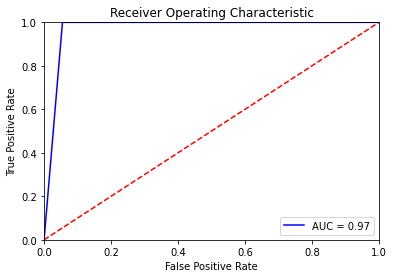

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        91
         1.0       0.95      1.00      0.97        87

    accuracy                           0.97       178
   macro avg       0.97      0.97      0.97       178
weighted avg       0.97      0.97      0.97       178

-------------------- AdaBoost -----------------------


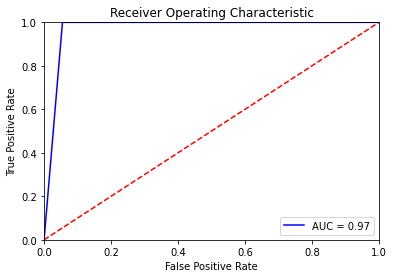

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        91
         1.0       0.95      1.00      0.97        87

    accuracy                           0.97       178
   macro avg       0.97      0.97      0.97       178
weighted avg       0.97      0.97      0.97       178

-------------------- XgBoost -----------------------


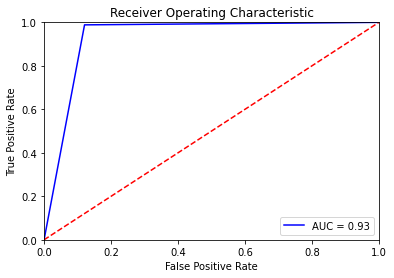

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93        91
         1.0       0.89      0.99      0.93        87

    accuracy                           0.93       178
   macro avg       0.94      0.93      0.93       178
weighted avg       0.94      0.93      0.93       178

-------------------- LightGBM -----------------------


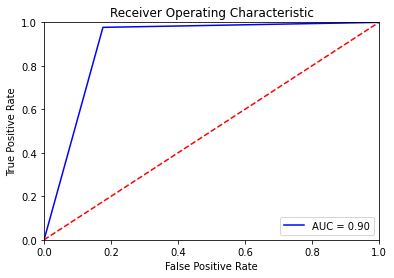

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89        91
         1.0       0.84      0.98      0.90        87

    accuracy                           0.90       178
   macro avg       0.91      0.90      0.90       178
weighted avg       0.91      0.90      0.90       178



In [ ]:
X_train, y_train, X_test, y_test = get_serialized_graph_data(graphs,train_index=2, test_index=3)
trainer = Classifiers(X_train, y_train, X_test, y_test)
trainer.train()
trainer.evaluate()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


[0]	eval-auc:0.692308	train-auc:0.970958
[1]	eval-auc:0.884615	train-auc:0.998551
[2]	eval-auc:0.980769	train-auc:1
[3]	eval-auc:1	train-auc:1
[4]	eval-auc:1	train-auc:1
[5]	eval-auc:1	train-auc:1
[6]	eval-auc:1	train-auc:1
[7]	eval-auc:1	train-auc:1
[8]	eval-auc:1	train-auc:1
[9]	eval-auc:1	train-auc:1
[1]	valid_0's binary_logloss: 0.643312	valid_0's auc: 0.97028
[2]	valid_0's binary_logloss: 0.618735	valid_0's auc: 1
[3]	valid_0's binary_logloss: 0.589051	valid_0's auc: 1
[4]	valid_0's binary_logloss: 0.555448	valid_0's auc: 1
[5]	valid_0's binary_logloss: 0.520983	valid_0's auc: 1
[6]	valid_0's binary_logloss: 0.502158	valid_0's auc: 1
[7]	valid_0's binary_logloss: 0.480226	valid_0's auc: 1
[8]	valid_0's binary_logloss: 0.467238	valid_0's auc: 1
[9]	valid_0's binary_logloss: 0.447603	valid_0's auc: 1
[10]	valid_0's binary_logloss: 0.426503	valid_0's auc: 1


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


-------------------- RandomForest -----------------------


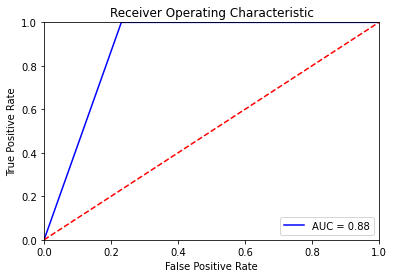

              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        26
         1.0       0.79      1.00      0.88        22

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.87        48
weighted avg       0.90      0.88      0.87        48

-------------------- AdaBoost -----------------------


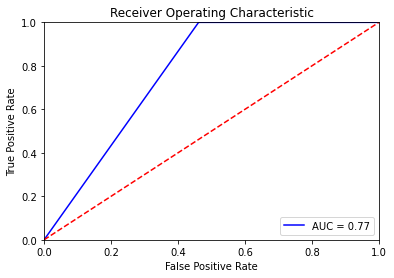

              precision    recall  f1-score   support

         0.0       1.00      0.54      0.70        26
         1.0       0.65      1.00      0.79        22

    accuracy                           0.75        48
   macro avg       0.82      0.77      0.74        48
weighted avg       0.84      0.75      0.74        48

-------------------- XgBoost -----------------------


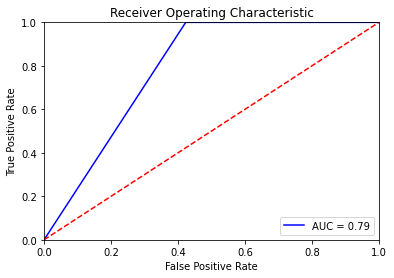

              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73        26
         1.0       0.67      1.00      0.80        22

    accuracy                           0.77        48
   macro avg       0.83      0.79      0.77        48
weighted avg       0.85      0.77      0.76        48

-------------------- LightGBM -----------------------


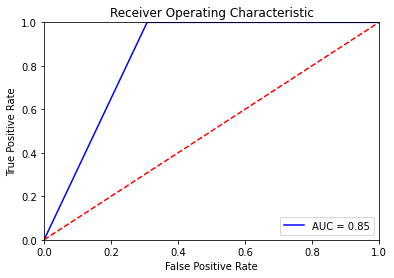

              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82        26
         1.0       0.73      1.00      0.85        22

    accuracy                           0.83        48
   macro avg       0.87      0.85      0.83        48
weighted avg       0.88      0.83      0.83        48



In [ ]:
X_train, y_train, X_test, y_test = get_serialized_graph_data(graph_ids, train_index=2, test_index=4)
trainer = Classifiers(X_train, y_train, X_test, y_test)
trainer.train()
trainer.evaluate()